<a href="https://colab.research.google.com/github/nedokormysh/Stepik_DS_Start/blob/main/AIRegressionCompetition_oob%2Boutliers%2Brealsub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install catboost -q
# !pip install pytorch-tabnet -q
!pip install optuna -q
!pip install optuna-integration -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
from typing import Any

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
# from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR

from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

from typing import Any, List, Tuple

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

import pickle
import warnings
warnings.simplefilter('ignore')

# Uploading data

In [ ]:
PATH_TRAIN = "https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/TrainDataFlight.csv"
PATH_TEST = "https://raw.githubusercontent.com/aiedu-courses/all_datasets/main/TestDataFlight.csv"

In [ ]:
TrainData = pd.read_csv(PATH_TRAIN)
TrainData.head()

,Species,Length1,Length2,Length3,Height,Width,Weight
0,Cypselurus,35.0,38.5,44.1,18.0369,6.3063,920.0
1,Hirundichthys,10.0,10.5,11.6,1.9720,1.1600,7.5
2,Cypselurus,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Exocoetus,24.0,26.0,29.2,8.8768,4.4968,290.0
4,Parexocoetus,18.4,20.0,22.4,8.8928,3.2928,150.0


In [ ]:
TestData = pd.read_csv(PATH_TEST)
TestData.head()

,Species,Length1,Length2,Length3,Height,Width
0,Hirundichthys,9.3,9.8,10.8,1.7388,1.0476
1,Fodiater,34.8,37.3,39.8,6.2884,4.0198
2,Parexocoetus,19.0,20.7,23.2,9.3960,3.4104
3,Cheilopogon,34.6,37.0,39.3,10.5717,6.3666
4,Exocoetus,21.1,22.5,25.0,6.4000,3.8000


# EDA

In [ ]:
TrainData.shape

(119, 7)

In [ ]:
sp = TrainData['Species'].value_counts()
sp = pd.DataFrame(sp)
sp.T

Species,Cheilopogon,Cypselurus,Exocoetus,Fodiater,Parexocoetus,Hirundichthys,Prognichthys
count,41,28,16,14,10,8,2


In [ ]:
# g = sns.pairplot(TrainData, kind='scatter', hue='Species')
# g.fig.set_size_inches(10,10)

In [ ]:
# # summary statistics
# TrainData.describe().style.background_gradient(cmap = "plasma")

In [ ]:
num_features = ['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Weight']

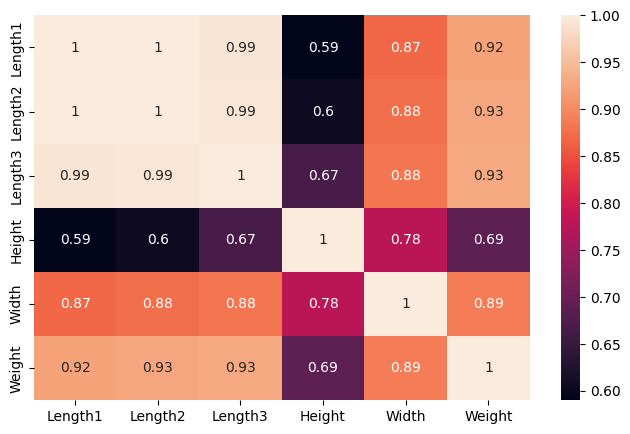

In [ ]:
# let's plot correlation matrix
plt.figure(figsize=(8,5))
sns.heatmap(TrainData[num_features].corr(), annot = True)
plt.show()

# Optimization

In [ ]:
# print('train')
# train = import_data(PATH_TRAIN)

# print('-' * 80)
# print('test')
# test = import_data(PATH_TEST)

In [ ]:
train = TrainData.copy()
test = TestData.copy()

In [ ]:
# train[num_features].boxplot();

# Data prep

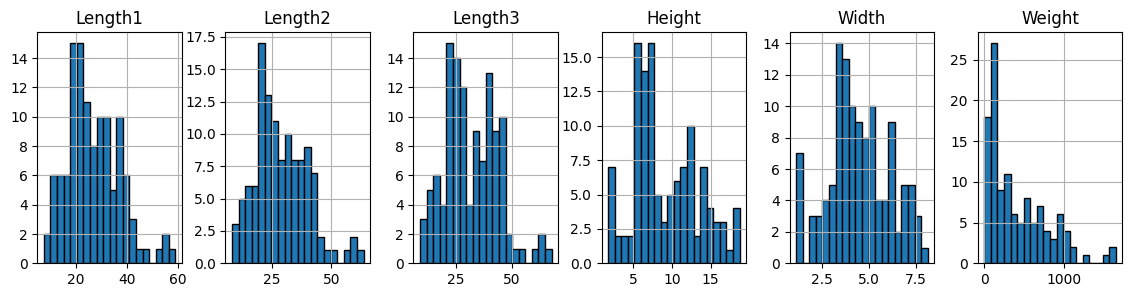

In [ ]:
train.hist(figsize=(14,3), layout=(-1,6), bins=20, edgecolor='black');

In [ ]:
train.drop('Species', axis=1).duplicated().any().any()

False

## Outliers

In [ ]:
train = train[train['Weight'] != 0]

### simple version

In [ ]:
Q1 = train[num_features].quantile(0.25)
Q3 = train[num_features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = pd.DataFrame(np.logical_or(train[num_features] < lower_bound, train[num_features] > upper_bound), columns=train[num_features].columns)
outliers.sum()

,0
Length1,3
Length2,3
Length3,1
Height,0
Width,0
Weight,3


In [ ]:
def find_outlier(name):
    # Вычисление Q1 и Q3 для столбца
    Q1 = train[name].quantile(0.25)
    Q3 = train[name].quantile(0.75)

    # Вычисление IQR
    IQR = Q3 - Q1

    # Определение верхней и нижней границ
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Отображение строк, где значения выходят за пределы границ
    filtered_train = train[(train[name] < lower_bound) | (train[name] > upper_bound)]

    return filtered_train

In [ ]:
find_outlier('Length1')

,Species,Length1,Length2,Length3,Height,Width,Weight
58,Fodiater,59.0,63.4,68.0,10.812,7.480,1650.0
66,Fodiater,56.0,60.0,64.0,9.600,6.144,1550.0
70,Fodiater,56.0,60.0,64.0,9.600,6.144,1600.0


In [ ]:
def replace_outliers_with_median(df, column_name):
    # Найти выбросы
    outliers = find_outlier(column_name)

    # Вычислить медиану столбца
    median_value = df[column_name].median()

    # Заменить выбросы на медианное значение
    df.loc[outliers.index, column_name] = median_value

    return df

In [ ]:
# смещение выбросов.
train = replace_outliers_with_median(train, 'Weight')
train = replace_outliers_with_median(train, 'Length1')
train = replace_outliers_with_median(train, 'Length2')
train = replace_outliers_with_median(train, 'Length3')

In [ ]:
# train.groupby('Species').agg('median')

In [ ]:
train.head()

,Species,Length1,Length2,Length3,Height,Width,Weight
0,Cypselurus,35.0,38.5,44.1,18.0369,6.3063,920.0
1,Hirundichthys,10.0,10.5,11.6,1.9720,1.1600,7.5
2,Cypselurus,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Exocoetus,24.0,26.0,29.2,8.8768,4.4968,290.0
4,Parexocoetus,18.4,20.0,22.4,8.8928,3.2928,150.0


### IsolationForest

In [ ]:
# lbls = ['Length1', 'Length2', 'Length3', 'Height', 'Width']

In [ ]:
# from sklearn.ensemble import IsolationForest

# isf = IsolationForest(n_jobs=-1, random_state=1)
# isf.fit(train[lbls], train['Weight'])

# isf.score_samples(train[lbls])

In [ ]:
# isf.predict(train[lbls])

In [ ]:
# # Предсказание выбросов
# train['anomaly'] = isf.predict(train[lbls])

# # Выбросы помечены как -1, нормальные данные как 1
# outliers = train[train['anomaly'] == -1]

# # Индексы выбросов
# outlier_indices = outliers.index

# # # Удаление выбросов из датасета
# train_cleaned = train.drop(outlier_indices)

# # Удаление столбца 'anomaly'
# train_cleaned = train_cleaned.drop(columns=['anomaly'])

# print("Индексы выбросов:", outlier_indices)
# print("Очищенный датасет:\n", train_cleaned)

### Local Outlier Factor

In [ ]:
# df1 = train.copy()

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor
# clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [ ]:
# y_pred = clf.fit_predict(df1)
# y_pred

In [ ]:
# X_scores = clf.negative_outlier_factor_

In [ ]:
# len(outlier_indices)

In [ ]:
train.describe()

,Length1,Length2,Length3,Height,Width,Weight
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,26.100000,28.273729,31.716949,9.209675,4.472618,385.160169
std,9.165981,9.831707,11.511193,4.248500,1.641717,322.053522
min,7.500000,8.400000,8.800000,1.728400,1.148400,5.900000
25%,19.500000,21.350000,23.500000,6.110000,3.398650,130.000000
50%,25.400000,27.500000,30.350000,7.789000,4.314050,292.500000
75%,32.525000,35.000000,39.675000,12.471000,5.521125,617.500000
max,52.000000,56.000000,64.000000,18.754200,8.142000,1250.000000


In [ ]:
train.duplicated().any().any()

True

In [ ]:
# # Проверка наличия значений inf в числовых столбцах
# numeric_columns = train.select_dtypes(include=[np.number]).columns
# inf_values = np.isinf(train[numeric_columns]).any().any()

# if inf_values:
#     print("В датасете есть значения inf.")
#     # Удаление строк с значениями inf
#     train = train.replace([np.inf, -np.inf], np.nan).dropna()
# else:
#     print("В датасете нет значений inf.")

# # Проверка результата
# train.describe()

## Aug

In [ ]:
# # Функция для генерации синтетических данных
# def generate_synthetic_data(df, n_samples):
#     synthetic_data = []
#     for _ in range(n_samples):
#         random_row = df.sample(1).values[0]
#         synthetic_row = random_row + np.random.normal(0, 0.1, size=random_row.shape)
#         synthetic_data.append(synthetic_row)
#     synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
#     return synthetic_df

# # Генерация синтетических данных
# n_samples = 100  # Количество синтетических данных
# synthetic_data = generate_synthetic_data(train, n_samples)

# # Добавление синтетических данных к исходному датасету
# train_augmented = pd.concat([train, synthetic_data], ignore_index=True)

# train_augmented.head()

In [ ]:
# train.drop('Weight', axis=1).boxplot();

In [ ]:
train.shape

(118, 7)

In [ ]:
# def add_noise(data, noise_level=0.01):
#     return data * (1 + noise_level * np.random.randn(*data.shape))

# train_noisy = train.copy()
# train_noisy[['Length1', 'Length2', 'Length3', 'Height', 'Width']] = add_noise(train[['Length1', 'Length2', 'Length3', 'Height', 'Width']])
# train = pd.concat([train, train_noisy], axis=0)


In [ ]:
train.shape

(118, 7)

## New features

In [ ]:
n = 1

In [ ]:
# Список колонок, для которых нужно создать новые колонки с log1p
columns_to_transform = ['Length1', 'Length2', 'Length3', 'Height', 'Width']

# Создание новых колонок с log1p
for col in columns_to_transform:
    train[f'log1p_{col}'] = np.log1p(train[col])

In [ ]:
train[f'Length{n}/Heigth'] = train[f'Length{n}'] / train['Height']
train[f'Length{n}/Width'] = train[f'Length{n}'] / train['Width']
train['Length1/Length2'] = train['Length1'] / train['Length2']
train['Length2/Length3'] = train['Length2'] / train['Length3']
train['Length1/Length3'] = train['Length1'] / train['Length3']
train['Height/Width'] = train['Height'] / train['Width']

train['Mean_Length'] = train[['Length1', 'Length2', 'Length3']].mean(axis=1)
train['Volume'] = train['Mean_Length'] * train['Width'] * train['Height']

train['Area'] = train['Length1'] * train['Width']
train['Volume_2'] = train['Length1'] * train['Length2'] * train['Length3']

# # Добавление скевности и эксцесса
# for col in ['Length1', 'Length2', 'Length3', 'Height', 'Width']:
#     train[f'{col}_skew'] = train.groupby('Species')[col].transform(lambda x: x.skew())
#     train[f'{col}_kurt'] = train.groupby('Species')[col].transform(lambda x: x.kurt())

# Добавление средних значений по видам
train[f'Length{n}_mean'] = train.groupby('Species')[f'Length{n}'].transform('mean')
train['Height_mean'] = train.groupby('Species')['Height'].transform('mean')
train['Width_mean'] = train.groupby('Species')['Width'].transform('mean')

# Добавление медианных значений по видам
train[f'Length{n}_median'] = train.groupby('Species')[f'Length{n}'].transform('median')
train['Height_median'] = train.groupby('Species')['Height'].transform('median')
train['Width_median'] = train.groupby('Species')['Width'].transform('median')

# Добавление стандартных отклонений по видам
train[f'Length{n}_std'] = train.groupby('Species')[f'Length{n}'].transform('std')
train['Height_std'] = train.groupby('Species')['Height'].transform('std')
train['Width_std'] = train.groupby('Species')['Width'].transform('std')

# Добавление минимальных значений по видам
train[f'Length{n}_min'] = train.groupby('Species')[f'Length{n}'].transform('min')
train['Height_min'] = train.groupby('Species')['Height'].transform('min')
train['Width_min'] = train.groupby('Species')['Width'].transform('min')

# Добавление максимальных значений по видам
train[f'Length{n}_max'] = train.groupby('Species')[f'Length{n}'].transform('max')
train['Height_max'] = train.groupby('Species')['Height'].transform('max')
train['Width_max'] = train.groupby('Species')['Width'].transform('max')


train['Length1_mean_diff'] = train['Length1'] - train['Length1_mean']
train['Height/Width_mean_ratio'] = train['Height'] / train['Width_mean']

train['sqrt_Height'] = np.sqrt(train['Height'])
train['sqrt_Width'] = np.sqrt(train['Width'])
train[f'sqrt_Length{1}'] = np.sqrt(train[f'Length{n}'])

In [ ]:
# Создание новых колонок с log1p
for col in columns_to_transform:
    test[f'log1p_{col}'] = np.log1p(test[col])

In [ ]:
test[f'Length{n}/Heigth'] = test[f'Length{n}'] / test['Height']
test[f'Length{n}/Width'] = test[f'Length{n}'] / test['Width']

test['Length1/Length2'] = test['Length1'] / test['Length2']
test['Length2/Length3'] = test['Length2'] / test['Length3']
test['Length1/Length3'] = test['Length1'] / test['Length3']

test['Height/Width'] = test['Height'] / test['Width']

test['Mean_Length'] = test[['Length1', 'Length2', 'Length3']].mean(axis=1)
test['Volume'] = test['Mean_Length'] * test['Width'] * test['Height']

test['Area'] = test['Length1'] * test['Width']
test['Volume_2'] = test['Length1'] * test['Length2'] * test['Length3']

# # Добавление скевности и эксцесса
# for col in ['Length1', 'Length2', 'Length3', 'Height', 'Width']:
#     test[f'{col}_skew'] = test.groupby('Species')[col].transform(lambda x: x.skew())
#     test[f'{col}_kurt'] = test.groupby('Species')[col].transform(lambda x: x.kurt())

# Добавление средних значений по видам
test[f'Length{n}_mean'] = test.groupby('Species')[f'Length{n}'].transform('mean')
test['Height_mean'] = test.groupby('Species')['Height'].transform('mean')
test['Width_mean'] = test.groupby('Species')['Width'].transform('mean')

# Добавление медианных значений по видам
test[f'Length{n}_median'] = test.groupby('Species')[f'Length{n}'].transform('median')
test['Height_median'] = test.groupby('Species')['Height'].transform('median')
test['Width_median'] = test.groupby('Species')['Width'].transform('median')

# Добавление стандартных отклонений по видам
test[f'Length{n}_std'] = test.groupby('Species')[f'Length{n}'].transform('std')
test['Height_std'] = test.groupby('Species')['Height'].transform('std')
test['Width_std'] = test.groupby('Species')['Width'].transform('std')

# Добавление минимальных значений по видам
test[f'Length{n}_min'] = test.groupby('Species')[f'Length{n}'].transform('min')
test['Height_min'] = test.groupby('Species')['Height'].transform('min')
test['Width_min'] = test.groupby('Species')['Width'].transform('min')

# Добавление максимальных значений по видам
test[f'Length{n}_max'] = test.groupby('Species')[f'Length{n}'].transform('max')
test['Height_max'] = test.groupby('Species')['Height'].transform('max')
test['Width_max'] = test.groupby('Species')['Width'].transform('max')

test['Length1_mean_diff'] = test['Length1'] - test['Length1_mean']
test['Height/Width_mean_ratio'] = test['Height'] / test['Width_mean']


test['sqrt_Height'] = np.sqrt(test['Height'])
test['sqrt_Width'] = np.sqrt(test['Width'])
test[f'sqrt_Length{1}'] = np.sqrt(test[f'Length{n}'])

In [ ]:
train.shape, test.shape

((118, 42), (40, 41))

In [ ]:
train.columns

Index(['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width', 'Weight',
       'log1p_Length1', 'log1p_Length2', 'log1p_Length3', 'log1p_Height',
       'log1p_Width', 'Length1/Heigth', 'Length1/Width', 'Length1/Length2',
       'Length2/Length3', 'Length1/Length3', 'Height/Width', 'Mean_Length',
       'Volume', 'Area', 'Volume_2', 'Length1_mean', 'Height_mean',
       'Width_mean', 'Length1_median', 'Height_median', 'Width_median',
       'Length1_std', 'Height_std', 'Width_std', 'Length1_min', 'Height_min',
       'Width_min', 'Length1_max', 'Height_max', 'Width_max',
       'Length1_mean_diff', 'Height/Width_mean_ratio', 'sqrt_Height',
       'sqrt_Width', 'sqrt_Length1'],
      dtype='object')

In [ ]:
# Определяем колонки, к которым хотим добавить полиномиальные признаки
selected_features = ['Length1', 'Length2', 'Length3', 'Height',
                     'Width', 'log1p_Length1', 'log1p_Length2', 'log1p_Length3',
                     'log1p_Height', 'log1p_Width', 'Length1/Heigth',
                     'Length1/Width', 'Length1/Length2', 'Length2/Length3',
                     'Length1/Length3', 'Height/Width',# 'Mean_Length',
                     'Volume','Area',
                    #  'Volume_2', 'Length1_mean_diff',
                    #  'Height/Width_mean_ratio',
                    #  'sqrt_Height', 'sqrt_Width', 'sqrt_Length1'
                     ]

# Добавляем полиномиальные признаки только к выбранным колонкам
poly = PolynomialFeatures(degree=3, include_bias=False)
train_selected_poly = poly.fit_transform(train[selected_features])

# Преобразуем полиномиальные признаки в DataFrame
poly_feature_names = poly.get_feature_names_out(selected_features)
train_selected_poly = pd.DataFrame(train_selected_poly, columns=poly_feature_names, index=train.index)

# Объединяем полиномиальные признаки с оригинальными признаками
train = pd.concat([train.drop(selected_features, axis=1), train_selected_poly], axis=1)

In [ ]:
# train.drop('Species', axis=1).corr()

In [ ]:
# Добавляем полиномиальные признаки к числовым признакам в тестовом датасете
test_selected_poly = poly.transform(test[selected_features])

# Преобразуем полиномиальные признаки в DataFrame
test_selected_poly = pd.DataFrame(test_selected_poly, columns=poly_feature_names, index=test.index)

# Объединяем числовые и полиномиальные признаки с категориальными признаками
test = pd.concat([test.drop(selected_features, axis=1), test_selected_poly], axis=1)

In [ ]:
train.shape, test.shape

((118, 1353), (40, 1352))

In [ ]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки, которые не потребуются для анализа.
cat_features = ['Species']
cat_features_indxs = [0]
targets = ['Weight']
features2drop = [
    # 'Length1',
    'Length2',
    'Length3',
    ]

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['Species'], amount = 1
num_features: ['Mean_Length', 'Volume_2', 'Length1_mean', 'Height_mean', 'Width_mean', 'Length1_median', 'Height_median', 'Width_median', 'Length1_std', 'Height_std', 'Width_std', 'Length1_min', 'Height_min', 'Width_min', 'Length1_max', 'Height_max', 'Width_max', 'Length1_mean_diff', 'Height/Width_mean_ratio', 'sqrt_Height', 'sqrt_Width', 'sqrt_Length1', 'Length1', 'Height', 'Width', 'log1p_Length1', 'log1p_Length2', 'log1p_Length3', 'log1p_Height', 'log1p_Width', 'Length1/Heigth', 'Length1/Width', 'Length1/Length2', 'Length2/Length3', 'Length1/Length3', 'Height/Width', 'Volume', 'Area', 'Length1^2', 'Length1 Length2', 'Length1 Length3', 'Length1 Height', 'Length1 Width', 'Length1 log1p_Length1', 'Length1 log1p_Length2', 'Length1 log1p_Length3', 'Length1 log1p_Height', 'Length1 log1p_Width', 'Length1 Length1/Heigth', 'Length1 Length1/Width', 'Length1 Length1/Length2', 'Length1 Length2/Length3', 'Length1 Length1/Length3', 'Length1 Height/Width', 'Le

In [ ]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    train[col] = train[col].astype("category")

for col in cat_features:
    test[col] = test[col].astype("category")

In [ ]:
# инициализируем номер случайного состояния, словарь лучших моделей, словарь для результатов
# датасет для формирования результатов
R_S = 7575
N_EST = 400
N_TRIALS = 200
sampler = optuna.samplers.TPESampler(seed=R_S)
TOP_F = 180
bst_mdls = {}
mean_scores = {}

df_sub = test.copy()

# Split

In [ ]:
# получаем разбиение на фичи и целевую переменную
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["Weight"]

In [ ]:
# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.15,
                                                  random_state=R_S,
                                                  stratify=X['Species'])

In [ ]:
# подготовка тестовых данных
X_sub = test[filtered_features].drop(targets, axis=1, errors="ignore")


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_sub shape: {X_sub.shape}")
print(f"X shape: {X.shape}")

X_train shape: (100, 1350)
X_sub shape: (40, 1350)
X shape: (118, 1350)


# Additional functions

## Класс для нормализации цифровых признаков

In [ ]:
class CustomTransformer(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    '''
    def __init__(self,
                 scaler_type: Any=None,
                 cat_feats: list[str]=None,
                 with_mean: bool=True,
                 with_std: bool=True,
                 feature_range: tuple[int, int]=(0, 1)):

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> pd.DataFrame:

        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        num_feats = [i for i in X_.columns if i not in self.cat_feats]

        X_num_trans = X_[num_feats]
        X_num_trans = pd.DataFrame(self.scaler.fit_transform(X_num_trans), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num_trans], axis=1)

        return res.set_index('index')

## Функция для шага обучения

In [ ]:
# функция для шага обучения
def lr_gen_simple(init_lr: float=0.1, epoch: int=400) -> list[float]:
    '''
    :param init_lr: initial number for learning rate
    :type init_lr: float, defaults to 0.1
    :param epoch: amount of epochs
    :type epoch: int, defaults to 400

    :rtype: list[float]

    .. notes:: Функция для формирования листа со значениями шага обучения
    на каждой эпохе.
    -----
    Параметры:
    init_lr - инициализирующий шаг обучения
    epoch - количество эпох

    '''
    decay = init_lr / epoch
    lr_list = [init_lr/(1 + decay * i) for i in range(1, epoch + 1)]

    return lr_list

## Класс для применения моделей.

In [ ]:
class FitClass:
    '''
    Класс для применения моделей.
    preparing_features - функция для создания пайплайнов обработки
    fit - применение модели
    '''
    @staticmethod
    def preparing_features(name: str, algorithm: Any,
                           num_top:int
                           ) -> Tuple[Any, Any]:


        '''
        :param name: name of regressor algorithm
        :type name: str
        :param algorithm: class of regressor algorithm
        :type algorithm: Any

        :rtype: Tuple[Any, Any]
        :returns: preprocessor pipe for columns and pipe model

        .. notes::
        -----
        Принимает на вход название алгоритма и алгоритм.
        Возвращает цепочку для преобразования фичей,
        цепочку для преобразования фичей и применения модели.
        '''

        if name == 'CatBoostRegressor':
            preprocessor = CustomTransformer(True, cat_feats=cat_features)
            pipe = Pipeline([
                ('feature_preprocessor', preprocessor),
                ('model', algorithm)
            ])
        else:
            numeric_transformer = Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())
                ]
            )
            categorical_transformer = Pipeline(
                steps=[
                    ("encoder", OneHotEncoder(handle_unknown="ignore"))
                ]
            )
            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", numeric_transformer, num_features),
                    ("cat", categorical_transformer, cat_features)
                ]
            )

            pipe = Pipeline([
                ('feature_preprocessor', preprocessor),
                ('feature_selection', SelectKBest(score_func=f_regression, k=num_top)),
                ('model', algorithm)
            ])
        return preprocessor, pipe

    @staticmethod
    def fit(name: str,
            pipe: Any,
            preprocessor: Any,
            X_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_train: pd.Series,
            y_val: pd.Series,
            fit_params: dict,
            callbacks=[]):
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param pipe: pipe of preprocessor for features and model
        :type pipe: Any
        :param preprocessor: pipe of preprocessor for features
        :type preprocessor: Any
        :param X_train: train features
        :type X_train: pandas.DataFrame
        :param X_val: validation features
        :type X_val: pandas.DataFrame
        :param y_train: train target
        :type y_train: pandas.Series
        :param y_val: validation target
        :type y_val: pandas.Series

        :rtype: Tuple[np.array, Any]
        :returns: array of predictions, model
        .. notes::
        -----
        Принимает название алгоритма. Применяет алгоритм с заданными параметрами
        к данным.
        Возвращает предсказание. И обученную модель.
        '''

        if name == 'TabNetRegressor':
            target_sc = StandardScaler()
            y_train = target_sc.fit_transform(y_train.values.reshape(-1, 1))
            X_val_eval_NN = X_val.copy()
            eval_set_pipe = Pipeline(steps=[('feature_preprocessor', preprocessor)])
            X_val_eval_NN = eval_set_pipe.fit(X_train).transform(X_val_eval_NN)
            y_val_eval_NN = target_sc.transform(y_val.values.reshape(-1, 1))
        else:
            X_val_eval = X_val.copy()
            eval_set_pipe = Pipeline(steps=[('feature_preprocessor', preprocessor)])
            X_val_eval = eval_set_pipe.fit(X_train).transform(X_val_eval)

        wrapped_model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

        if name in ['KNeighborsRegressor',
                    'ElasticNet',
                    'RandomForestRegressor',
                    'GaussianProcessRegressor',
                    'NuSVR',
                    'MLPRegressor',
                    'GradientBoostingRegressor',
                    'LinearRegression']:
            wrapped_model.fit(X_train,
                              y_train,
                              **fit_params)
            y_pred = wrapped_model.predict(X_val)
        elif name == 'TabNetRegressor':
            pipe.fit(X_train, y_train,
                    model__eval_set=[(X_val_eval_NN, y_val_eval_NN)],
                    **fit_params)
            y_pred = pipe.predict(X_val)
            y_pred = target_sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
            wrapped_model = pipe

        else:
            if callbacks:
                wrapped_model.fit(X_train,
                                  y_train,
                                  **fit_params,
                                  model__callbacks=callbacks,
                                  model__eval_set=[(X_val_eval, y_val)])
                # запускаем процесс прунинга для catboost
                if name == 'CatBoostRegressor':
                    callbacks[-1].check_pruned()
            else:
                wrapped_model.fit(X_train,
                                  y_train,
                                  model__eval_set=[(X_val_eval, y_val)],
                                  **fit_params)

            y_pred = wrapped_model.predict(X_val)

        if name == 'TabNetRegressor':
            return y_pred, wrapped_model, target_sc

        return y_pred, wrapped_model

## Fit algorithm optuna

In [ ]:
# функция применения алгоритма, когда применяем optuna
def fit_algorithm_optuna(trial: optuna.trial,
                         train: pd.DataFrame,
                         val: pd.DataFrame,
                         algorithm: Any,
                         init_params: dict,
                         grid: dict,
                         fit_params: dict,
                         r_s=R_S,
                         callbacks = []):
    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pandas.DataFrame
    :param algorithm: class of regressor algorithm
    :type algorithm: Any
    :param init_params: initial parameters
    :type init_params: dict
    :param grid: grid of parameters
    :type grid: dict
    :param fit_params: parameters to fit
    :type fit_params: dict
    :param r_s: random state
    :type r_s: int, defaults to 7575
    :param callbacks: callbacks
    :type callbacks: list, defaults to []

    :rtype: tuple[Any, np.array]
    :returns: model, array of predictions
    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки.
    '''

    X_train, y_train = train
    X_val, y_val = val

    # получаем на вход сетку с параметрами для перебора. для пары алгоритмов будем
    # добавлять параметры в сетку, в зависимости от некоторых условий.
    if algorithm.__name__ == 'CatBoostRegressor':
        if grid["bootstrap_type"] == "Bayesian":
            grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif grid["bootstrap_type"] == "Bernoulli":
            grid["subsample"] = trial.suggest_float("subsample", 0.1, 1, step=0.01)
    elif algorithm.__name__ == 'XGBRegressor':
        if grid["booster"] == "gbtree" or grid["booster"] == "dart":
            grid["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            grid["tree_method"]: trial.suggest_categorical("tree_method", ['hist', 'approx'],)
        if grid["booster"] == "dart":
            grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    elif algorithm.__name__ == 'LGBMRegressor':
        if init_params['boosting_type'] != 'goss':
            grid['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.5, 1.0, step=0.01)
            grid['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)
        if init_params['boosting_type'] == 'dart':
            grid['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.5, step=0.01)

    # Remove 'num_features' from grid before initializing the algorithm

    # num_top_value = grid.pop('num_top')



    # Сходу не придумал как нормально в этой схеме передавать Num_top
    # - количество признаков для отбора.
    # Весь этот блок был написан для случая, когда я уже подобрал какие-то границы
    # или точное значение количества признаков. И тут лишь хочу его ограничить.
    # изначално пользовался только вот самой первой строчкой в этом блоке
    # num_top = trial.suggest_int("num_top", 1, X.shape[1], step=20)
    if algorithm.__name__ == 'KNeighborsRegressor':
        num_top = trial.suggest_int("num_top", 401, 404, step=1)
    elif algorithm.__name__ == 'ElasticNet':
        num_top = trial.suggest_int("num_top", 910, X.shape[1], step=20)
    elif algorithm.__name__ == 'GradientBoostingRegressor':
        num_top = trial.suggest_int("num_top", 1, X.shape[1], step=20)
    elif algorithm.__name__ == 'RandomForestRegressor':
        num_top = trial.suggest_int("num_top", 400, 1000, step=20)
    elif algorithm.__name__ == 'NuSVR':
        num_top = trial.suggest_int("num_top", 1, X.shape[1], step=20)





    rgr = algorithm(**init_params, **grid)

    # применяем метод preparing_features - он на вернёт способ обработки данных и общий пайплайн модели
    preprocessor, pipe = FitClass.preparing_features(algorithm.__name__,
                                                     rgr,
                                                     num_top
                                                     )

    # для алгоритма TabNet будем возвращать ещё и обученный объект scaler для целевой переменной
    if algorithm.__name__ == 'TabNetRegressor':
        y_pred, wrapped_model, target_sc = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
        return wrapped_model, y_pred, target_sc

    y_pred, wrapped_model = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)

    # возвращаем модель и прогноз
    return wrapped_model, y_pred


# Models

In [ ]:
df_sub = pd.DataFrame()

In [ ]:
submition_df = pd.read_csv('/content/sub_40.csv')

## KNN

In [ ]:
def objective_knn(trial, return_models=False):
    init_params = { 'n_jobs': -1 }

    grid = {
             'weights': trial.suggest_categorical("weights", [#'uniform',
                                                              'distance'
                                                              ],),
             'algorithm': trial.suggest_categorical("algorithm", ['ball_tree',
                                                              # 'kd_tree',
                                                              # 'brute',
                                                              #  'auto'
                                                              ],),
             'n_neighbors': 7,#trial.suggest_int("n_neighbors", 7, 10, step=1),
             'leaf_size': 413,# trial.suggest_int("leaf_size", 400, 500, step=1),
             'p':  trial.suggest_int("p", 2, 3),
            #  'num_top': trial.suggest_int("num_top", 1, X.shape[1], step=20)
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             KNeighborsRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)
        # sc_tr = r2_score(y_true=submition_df['Weight'], y_pred=model.predict(X_sub))
        # scores.append(sc_tr)
        oob.append(model.predict(X_sub))

        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize", study_name="KNN_Regressor", sampler=sampler)
study.optimize(objective_knn,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.86 s, sys: 89.7 ms, total: 2.95 s
Wall time: 2.54 s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['KNN_score'], bst_mdls['KNN_model'], oob_res = objective_knn(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)


Best trial: score 0.9674556572148864, params {'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2, 'num_top': 141}


In [ ]:

    # grid = {
    #          'weights': trial.suggest_categorical("weights", [#'uniform',
    #                                                           'distance'
    #                                                           ],),
    #          'algorithm': trial.suggest_categorical("algorithm", ['ball_tree',
    #                                                           # 'kd_tree',
    #                                                           # 'brute',
    #                                                           #  'auto'
    #                                                           ],),
    #          'n_neighbors': trial.suggest_int("n_neighbors", 7, 10, step=1),
    #          'leaf_size': trial.suggest_int("leaf_size", 400, 500, step=1),
    #          'p':  trial.suggest_int("p", 1, 3),
    #         #  'num_top': trial.suggest_int("num_top", 1, X.shape[1], step=20)
    #          }


# Best trial: score 0.9720568230293948, params {'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 8, 'leaf_size': 413, 'p': 1, 'num_top': 41}

In [ ]:
# Best trial: score 0.986243750199019, params {'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 9, 'leaf_size': 444, 'p': 1, 'num_top': 1}

In [ ]:
# Best trial: score 0.9848209610005932, params {'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 7, 'leaf_size': 493, 'p': 3, 'num_top': 401}

In [ ]:
# Best trial: score 0.986243750199019, params {'weights': 'distance', 'algorithm': 'ball_tree', 'n_neighbors': 9, 'leaf_size': 303, 'p': 2, 'num_top': 1}

In [ ]:
# knn_best_params = study.best_params

In [ ]:
# optuna.visualization.plot_slice(study)

In [ ]:
# Сделаем прогноз для тестовых данных
preds = np.mean(oob_res, axis=0)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['KNN_target'] = preds
df_sub.head()

,KNN_target
0,9.593995
1,315.415078
2,146.946684
3,677.591687
4,150.630077


In [ ]:
r2_score(submition_df['Weight'], df_sub['KNN_target'])

0.9851665328732383

In [ ]:
# 0.987995337786958

In [ ]:
# 0.9881463664202823

In [ ]:
# df_sub.rename(columns={'KNN_target': 'predictions'}).to_csv('output.csv', index=False)

## Elastic net

In [ ]:
def objective_elastik(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {'max_iter': trial.suggest_int("max_iter", 2600, 2800, step=4),
            'l1_ratio': trial.suggest_float("l1_ratio", 0.001, 0.03, step=0.01),
            'alpha':  trial.suggest_float("alpha", 0.001, 0.05, step=0.01),
            # 'num_top': trial.suggest_int("num_top", 1, X.shape[1], step=20)
            }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             ElasticNet,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)
        sc_tr = r2_score(y_true=submition_df['Weight'], y_pred=model.predict(X_sub))
        # scores.append(sc_tr)
        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="Elastic_Regressor", sampler=sampler)
study.optimize(objective_elastik,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 8min 7s, sys: 2.23 s, total: 8min 10s
Wall time: 5min 20s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Elastic_score'], bst_mdls['Elastic_model'], oob_res = objective_elastik(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.97608314501884, params {'max_iter': 2800, 'l1_ratio': 0.001, 'alpha': 0.031, 'num_top': 1250}


In [ ]:
# Best trial: score 0.9809346251893268, params {'max_iter': 2708, 'l1_ratio': 0.031, 'alpha': 0.011, 'num_top': 1201}

In [ ]:
# Best trial: score 0.9804630899146902, params {'max_iter': 2724, 'l1_ratio': 0.041, 'alpha': 0.011, 'num_top': 101}

In [ ]:
# Best trial: score 0.9811926260412168, params {'max_iter': 2744, 'l1_ratio': 0.011, 'alpha': 0.011, 'num_top': 541}

In [ ]:
elastic_best_params = study.best_params

In [ ]:
preds = bst_mdls['Elastic_model'].predict(X_sub)#np.mean(oob_res, axis=0)
df_sub['Elastic_target'] = preds

In [ ]:
# df_sub['Elastic_target']

In [ ]:
r2_score(submition_df['Weight'], df_sub['Elastic_target'])

0.9834156315319521

## Gradient_boosting

In [ ]:
def objective_gradient_boosting(trial, return_models=False):
    init_params = {'random_state': R_S,
                  #  'n_jobs': -1
                   }

    grid = { 'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
             'n_estimators': trial.suggest_int("n_estimators", 1000, 3000, step=4),
             'subsample': trial.suggest_float("subsample", 0.6, 0.95, step=0.01),
             'criterion': trial.suggest_categorical("criterion", [#"friedman_mse",
                                                                  "squared_error"
                                                                  ]),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 50, step=5),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 50, step=5),
             'max_depth': trial.suggest_int("max_depth", 1, 8),
             'n_iter_no_change': trial.suggest_int("n_iter_no_change", 40, 70, step=2)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []
    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             GradientBoostingRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        # sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        # scores.append(sc)
        models.append(model)
        sc_tr = r2_score(y_true=submition_df['Weight'], y_pred=model.predict(X_sub))
        scores.append(sc_tr)
        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="GB_Regressor", sampler=sampler)
study.optimize(objective_gradient_boosting,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2h 55min 10s, sys: 19.1 s, total: 2h 55min 29s
Wall time: 1h 47min 29s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['GB_score'], bst_mdls['GB_model'], oob_res = objective_gradient_boosting(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.985318068296147, params {'learning_rate': 0.0029452787703616993, 'n_estimators': 2348, 'subsample': 0.63, 'criterion': 'squared_error', 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_depth': 7, 'n_iter_no_change': 48, 'num_top': 1281}


In [ ]:
# {'learning_rate': 0.0029452787703616993, 'n_estimators': 2348, 'subsample': 0.63, 'criterion': 'squared_error', 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_depth': 7, 'n_iter_no_change': 48, 'num_top': 1281}

In [ ]:
# Best trial: score 0.9847074615384424, params {'n_estimators': 1116, 'subsample': 0.61, 'criterion': 'squared_error', 'min_samples_split': 22, 'min_samples_leaf': 7, 'max_depth': 8, 'n_iter_no_change': 60, 'num_top': 401}

In [ ]:
# 0.989574951178261

In [ ]:
preds = np.mean(oob_res, axis=0)
df_sub['GB_target'] = preds

In [ ]:
r2_score(submition_df['Weight'], df_sub['GB_target'])

0.9873112346987115

In [ ]:
# 0.989574951178261

In [ ]:
# df_sub.rename(columns={'GB_target': 'predictions'}).to_csv('output_gb_0.csv', index=False)

In [ ]:
params = {}

## Random Forest

In [ ]:
def objective_random_forest(trial, return_models=False):
    init_params = {'random_state': R_S,
                   'n_jobs': -1}

    grid = { 'n_estimators': trial.suggest_int("n_estimators", 350, 450, step=4),
             'max_depth': trial.suggest_int("max_depth", 3, 6),
             'max_samples': trial.suggest_int("max_samples", 70, 79, step=2),
             'min_samples_split': trial.suggest_float("min_samples_split", 0.1, 0.5, step=0.05),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
            #  'bootstrap': trial.suggest_categorical("bootstrap", [True, False])
            }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             RandomForestRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)
        # sc_tr = r2_score(y_true=submition_df['Weight'], y_pred=model.predict(X_sub))
        # scores.append(sc_tr)
        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result


In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="Random_Forest_Regressor", sampler=sampler)
study.optimize(objective_random_forest,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 1h 31min 35s, sys: 50.8 s, total: 1h 32min 25s
Wall time: 56min


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['RF_score'], bst_mdls['RF_model'], oob_res = objective_random_forest(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.9681603460690776, params {'n_estimators': 430, 'max_depth': 6, 'max_samples': 78, 'min_samples_split': 0.1, 'min_samples_leaf': 1, 'num_top': 960}


In [ ]:
preds = np.mean(oob_res, axis=0)
df_sub['RF_target'] = preds

In [ ]:
r2_score(submition_df['Weight'], df_sub['RF_target'])

0.9859494223447037

## SVM

In [ ]:
def objective_svm(trial, return_models=False):
    init_params = {}

    grid = {'max_iter': trial.suggest_int('max_iter', 600, 700, step=10),
            'nu': trial.suggest_float("nu", 0.5, 0.65, step=0.01),
            'C': trial.suggest_float("C", 20, 28, step=0.01)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []
    oob = []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             NuSVR,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        sc = r2_score(y_true=y_true.tolist(), y_pred=y_pred.tolist())
        scores.append(sc)
        models.append(model)
        oob.append(model.predict(X_sub))
        # break

    bst_mdl = models[np.argmax(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, oob
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="maximize", study_name="SVM_Regressor", sampler=sampler)
study.optimize(objective_svm,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 1min 59s, sys: 2.24 s, total: 2min 1s
Wall time: 1min 50s


In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
# svm_best_params = study.best_params

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['SVM_score'], bst_mdls['SVM_model'], oob_res = objective_svm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 0.9640294980155374, params {'max_iter': 700, 'nu': 0.58, 'C': 22.78, 'num_top': 21}


In [ ]:
preds = np.mean(oob_res, axis=0)

df_sub['SVM_target'] = preds

In [ ]:
r2_score(submition_df['Weight'], df_sub['SVM_target'])

0.9828453383560606

# Сравнение моделей

In [ ]:
df_sub_ = df_sub.copy()

In [ ]:
def replace_negatives_with_mean(row):
    if row['Elastic_target'] < 0:
        mean_value = row[row > 0].mean()
        row['Elastic_target'] = mean_value
    return row

# Применение функции к каждой строке датафрейма
df_sub_ = df_sub_.apply(replace_negatives_with_mean, axis=1)

In [ ]:
# df_sub_

In [ ]:
def replace_negatives_with_mean(row):
    if row['Elastic_target'] < 10:
        mean_value = row[row > 0].mean()
        row['Elastic_target'] = mean_value
    return row

# Применение функции к каждой строке датафрейма
df_sub_ = df_sub_.apply(replace_negatives_with_mean, axis=1)

In [ ]:
# df_sub_

In [ ]:
mean_scores = {k: v for k, v in sorted(mean_scores.items(), key=lambda item: item[1])}
mean_scores

{'SVM_score': 0.9640294980155374,
 'KNN_score': 0.9674556572148864,
 'RF_score': 0.9681603460690776,
 'Elastic_score': 0.97608314501884,
 'GB_score': 0.985318068296147}

In [ ]:
# sns.set_style("whitegrid")

# mask = np.triu(np.ones_like(df_sub.corr(numeric_only=True), dtype=bool))

# heatmap = sns.heatmap(df_sub.corr(numeric_only=True).round(2),
#                       annot=True,
#                       square=True,
#                       cmap="BrBG",
#                       cbar_kws={"fraction": 0.01},
#                       linewidth=1,
#                       mask=mask)

# heatmap.set_title("Матрица корреляций результатов моделей", fontdict={"fontsize": 15}, pad=10);

In [ ]:
# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
df_val = pd.DataFrame()
df_val['target_val'] = y_val.values
scores = {}

for el in bst_mdls:
   y_pred = bst_mdls[el].predict(X_val)
   df_val[el] = y_pred
   scores[el] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)

<Axes: >

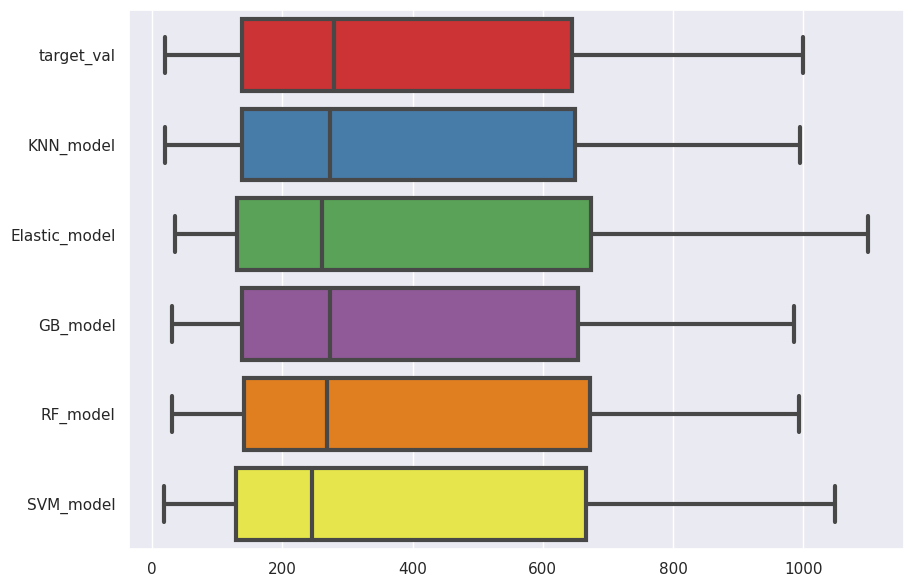

In [ ]:
sns.set(rc={"figure.figsize":(10, 7)})
sns.boxplot(data=df_val,whis=1,linewidth=3,orient="h",palette="Set1")

## Blend

In [ ]:
df_val

,target_val,KNN_model,Elastic_model,GB_model,RF_model,SVM_model
0,1000.0,994.382333,1100.084589,986.129151,993.061909,1048.431727
1,300.0,287.490401,275.126021,297.799186,271.825094,251.904377
2,800.0,671.445524,752.509350,792.415109,687.367364,677.629295
3,115.0,116.825908,122.156632,117.748743,116.931364,105.655555
4,260.0,260.000000,246.299154,247.358058,263.924819,239.278570
5,19.9,19.900000,35.275263,29.680389,29.780934,17.784234
6,720.0,720.000000,753.443436,734.344793,713.619821,740.124516
7,620.0,641.806252,648.559371,627.956363,668.206001,661.888671
8,145.0,145.000000,133.117771,145.169589,148.455190,135.406549
9,197.0,197.000000,198.069872,197.616637,204.099568,200.725523


In [ ]:
# 'RF_score': 0.9512251503814739,
#  'GB_score': 0.9564698329639243,
#  'LR_score': 0.9592503585419373,
#  'Elastic_score': 0.9610949473131014

In [ ]:
df_val_blending = df_val[[
                           'KNN_model',
                           'Elastic_model',
                          'GB_model',
                          'RF_model',
                          'SVM_model',
                          'target_val'
                          ]]
df_val_blending.head()

,KNN_model,Elastic_model,GB_model,RF_model,SVM_model,target_val
0,994.382333,1100.084589,986.129151,993.061909,1048.431727,1000.0
1,287.490401,275.126021,297.799186,271.825094,251.904377,300.0
2,671.445524,752.509350,792.415109,687.367364,677.629295,800.0
3,116.825908,122.156632,117.748743,116.931364,105.655555,115.0
4,260.000000,246.299154,247.358058,263.924819,239.278570,260.0


In [ ]:
import re

In [ ]:
scores_mdls_chosen = {}
for i in range(len(df_val_blending.columns)):
    _ = re.sub(r'_model', '_score', df_val_blending.columns[i])
    if _ in mean_scores:
        scores_mdls_chosen.update({_: mean_scores[_]})

scores_mdls_chosen

{'KNN_score': 0.9674556572148864,
 'Elastic_score': 0.97608314501884,
 'GB_score': 0.985318068296147,
 'RF_score': 0.9681603460690776,
 'SVM_score': 0.9640294980155374}

In [ ]:
# реал

# knn= 0.9851665328732383
# elastik = 0.9834156315319521
# gb = 0.9873112346987115
# rf = 0.9859494223447037
# svm = 0.9828453383560606

In [ ]:
# Преобразуем метрики в массив
scores = np.array(list(scores_mdls_chosen.values()))

# Нормализуем метрики, чтобы их сумма была равна 1
all_sum = np.sum(scores)
weights_ = scores / all_sum

# Создаем словарь с коэффициентами
weights = {}
for f, b in zip(scores_mdls_chosen, weights_):
    weights.update({f: b})

weights

{'KNN_score': 0.19902208598536617,
 'Elastic_score': 0.20079690698801472,
 'GB_score': 0.20269668780055922,
 'RF_score': 0.19916705247006844,
 'SVM_score': 0.19831726675599146}

In [ ]:
all_models = df_sub.columns.tolist()
sel_mdl = [
  'KNN_target',
 'Elastic_target',
 'GB_target',
 'RF_target',
 'SVM_target',
 ]

In [ ]:
df_sub_blending = df_sub_[sel_mdl]

In [ ]:
# Функция для вычисления взвешенного предсказания
def calculate_blended_prediction(df, weights):
    blended_prediction = 0
    for model, weight in weights.items():
        model_name = model.replace('_score', '_target')
        if model_name in df.columns:
            blended_prediction += df[model_name] * weight
    return blended_prediction

# Вычисление итогового предсказания
df_sub_blending['predictions'] = calculate_blended_prediction(df_sub_blending, weights)

In [ ]:
df_sub_blending.head()

,KNN_target,Elastic_target,GB_target,RF_target,SVM_target,predictions
0,9.593995,14.603663,25.411763,22.395256,10.296542,16.495047
1,315.415078,304.298348,345.249690,342.454658,318.428744,325.213306
2,146.946684,178.531612,167.083800,160.364455,161.321080,162.893635
3,677.591687,691.138766,679.054385,684.192810,653.604234,677.165983
4,150.630077,155.127591,153.037431,153.049955,157.812854,153.927555


In [ ]:
# вариант выставления весов вручную
# df_sub_blending['target_reg'] = df_sub_blending['Catboost_target'] * 0.445 + \
#      df_sub_blending['LGBM_target'] * 0.445 + df_sub_blending['SVM_target'] * 0.11
# df_sub_blending.head()

# выставление весов пропроционально средней метрике
# df_sub_blending['target_reg'] = df_sub_blending['Catboost_target'] * weights['Catboost_score'] + \
#      df_sub_blending['LGBM_target'] * weights['LGBM_score'] + df_sub_blending['SVM_target'] * weights['SVM_score']
# df_sub_blending.head()


In [ ]:
# вариант выставления весов вручную
df_sub_blending['predictions'] = df_sub_blending['GB_target'] * 0.65 + df_sub_blending['RF_target'] * 0.2 + df_sub_blending['KNN_target'] * 0.15
df_sub_blending.head()

,KNN_target,Elastic_target,GB_target,RF_target,SVM_target,predictions
0,9.593995,14.603663,25.411763,22.395256,10.296542,22.435796
1,315.415078,304.298348,345.249690,342.454658,318.428744,340.215492
2,146.946684,178.531612,167.083800,160.364455,161.321080,162.719363
3,677.591687,691.138766,679.054385,684.192810,653.604234,679.862665
4,150.630077,155.127591,153.037431,153.049955,157.812854,152.678833


In [ ]:
r2_score(submition_df['Weight'], df_sub_blending['predictions'])

0.9874755928924297

In [ ]:
# # получаем предсказания от блендинга
# df_sub_blending = df_sub.copy()
# df_sub_blending.to_csv('result_0.csv', index=False)

In [ ]:
df_sub_blending['predictions'].to_csv('result_3blend_oob_outl.csv', index=False)

In [ ]:
# # # Округление значений в колонке 'predictions' до одного знака после запятой
# df_sub_blending['predictions'] = df_sub_blending['predictions'].round(1)

# # df_sub_blending

In [ ]:
r2_score(submition_df['Weight'], df_sub_blending['predictions'])

0.9873731541770762

In [ ]:
# def process_predictions(value):
#     if value % 1 < 0.5:
#         return int(value)
#     else:
#         return value

# # Применение функции к столбцу 'predictions'
# df_sub_blending['predictions'] = df_sub_blending['predictions'].apply(process_predictions)

In [ ]:
# df_sub_blending['predictions'].to_csv('result_sintetic_round.csv', index=False)

## bestmodels pred

In [ ]:
df_sub.head()

,KNN_target,Elastic_target,GB_target,RF_target,SVM_target
0,9.593995,5.320762,25.411763,22.395256,10.296542
1,315.415078,304.298348,345.249690,342.454658,318.428744
2,146.946684,178.531612,167.083800,160.364455,161.321080
3,677.591687,691.138766,679.054385,684.192810,653.604234
4,150.630077,155.127591,153.037431,153.049955,157.812854


In [ ]:
df_blend_best = pd.DataFrame()

In [ ]:
df_blend_best['GB_best_target'] = bst_mdls['GB_model'].predict(X_sub)
df_blend_best['RF_best_target'] = bst_mdls['RF_model'].predict(X_sub)
df_blend_best['Elastik_best_target'] = bst_mdls['Elastic_model'].predict(X_sub)

In [ ]:
df_blend_best['predictions'] = df_blend_best['GB_best_target'] * 0.95 + \
                               + df_blend_best['RF_best_target'] * 0.025 + \
                               + df_blend_best['Elastik_best_target'] * 0.025

r2_score(submition_df['Weight'], df_blend_best['predictions'])

0.9884330250331195

In [ ]:
df_blend_best['predictions'].to_csv('blend_best.csv', index=False)

In [ ]:
# df_blend_best

## Single

In [ ]:
bst_mdls.keys()

dict_keys(['KNN_model', 'Elastic_model', 'GB_model', 'RF_model', 'SVM_model'])

In [ ]:
df_sub_mdl = df_sub.copy()
df_sub_mdl = df_sub_mdl.rename(columns={'RF_target': 'predictions'})
df_sub_mdl['predictions'].to_csv('RF_deg.csv', index=False)

In [ ]:
gb = 0.97722
svm = 0.94469
elastic = 0.96872
rf = 0.98242
knn = 0.95478

In [ ]:
# rf = 0.9826
# degree =2 len =3

In [ ]:
import joblib


# Сохранение моделей
for model_name, model in bst_mdls.items():
    joblib.dump(model, f'{model_name}.pkl')

print("Модели сохранены.")

## Stack

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# # список базовых моделей
# estimators = [
#     ("RF", bst_mdls['RF_model']),
#     ("Gradient", bst_mdls['GB_model']),
#     ("Elastik", bst_mdls['Elastic_model']),]

# meta_model = StackingRegressor(estimators=estimators,
#                                final_estimator=ElasticNet(max_iter=704,
#                                l1_ratio=0.23,
#                                alpha=0.004),
#                                n_jobs=-1,
#                                verbose=False)

# stacking_regressor = meta_model
# stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('RF',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median')),
                                                                                                                                      ('scaler',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['Mean_Length',
                                                                                                                       'Volume_2',
                                                                                                                       'Length1_mean',
                                                                                                                       'Height_mean',
                                                                                                                       'Width_mean',
                                                                                                                       'Length1_median',
                                                                                                                       'Height_median',
                                                                                                                       'Width...
                                                                                                                                       OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                                      ['Species'])])),
                                                                                    ('feature_selection',
                                                                                     SelectKBest(k=1250,
                                                                                                 score_func=<function f_regression at 0x7f65e3d88160>)),
                                                                                    ('model',
                                                                                     ElasticNet(alpha=0.031,
                                                                                                l1_ratio=0.001,
                                                                                                max_iter=2800,
                                                                                                random_state=7575))]),
                                                          transformer=StandardScaler()))],
                  final_estimator=ElasticNet(alpha=0.004, l1_ratio=0.23,
                                             max_iter=704),
                  n_jobs=-1, verbose=False)

In [ ]:
# список базовых моделей
estimators = [
    ("RF", bst_mdls['RF_model']),
    ("Gradient", bst_mdls['GB_model']),
    # ("Elastik", bst_mdls['Elastic_model']),
    ("KNN", bst_mdls['KNN_model'])
    ]

meta_model = StackingRegressor(estimators=estimators,
                               final_estimator=LinearRegression(),
                               n_jobs=-1,
                               verbose=False)

stacking_regressor = meta_model
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('RF',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median')),
                                                                                                                                      ('scaler',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['Mean_Length',
                                                                                                                       'Volume_2',
                                                                                                                       'Length1_mean',
                                                                                                                       'Height_mean',
                                                                                                                       'Width_mean',
                                                                                                                       'Length1_median',
                                                                                                                       'Height_median',
                                                                                                                       'Width...
                                                                                                                                       OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                                      ['Species'])])),
                                                                                    ('feature_selection',
                                                                                     SelectKBest(k=141,
                                                                                                 score_func=<function f_regression at 0x7f65e3d88160>)),
                                                                                    ('model',
                                                                                     KNeighborsRegressor(algorithm='ball_tree',
                                                                                                         leaf_size=413,
                                                                                                         n_jobs=-1,
                                                                                                         n_neighbors=7,
                                                                                                         weights='distance'))]),
                                                          transformer=StandardScaler()))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=False)

In [ ]:
r2_score(submition_df['Weight'], stacking_regressor.predict(X_sub))

0.9792851963532241

In [ ]:
preds = stacking_regressor.predict(X_sub)
df_sub_stacking = df_sub.copy()
df_sub_stacking['predictions'] = preds
df_sub_stacking['predictions'].to_csv('result_3_est_RF_Grad_KNN.csv', index=False)

In [ ]:
import joblib

In [ ]:
# Сохранение модели с помощью joblib
joblib.dump(stacking_regressor, 'stacking_regressor_model_2_RF_Els.pkl')

print("Модель сохранена.")

## Ansamble

In [ ]:
!git clone https://github.com/MLWave/Kaggle-Ensemble-Guide

In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_avg.py "/content/result_*.csv" "/content/all_blended.csv"

In [ ]:
df0 = pd.read_csv('/content/result_3blend_oob_outl.csv')
df0.shape

(40, 1)

In [ ]:
df1 = pd.read_csv('/content/blend_best.csv')
df1.shape

(40, 1)

In [ ]:
df3 = pd.read_csv('/content/result_3_est_RF_Grad_KNN.csv')
df3.shape

(40, 1)

In [ ]:
# df_blend_best

In [ ]:
df_ansamble = pd.concat([df0,
                         df1,
                         df3,
                         df_blend_best['GB_best_target']
                         ], axis=1)

# # Переименовать колонки для ясности
df_ansamble.columns = ['predictions_0', 'predictions_1', 'predictions_3',
                       'predictions_4']

# # Создать новую колонку с усредненными значениями
# df_ansamble['predictions'] = df_ansamble[['predictions_0',
#                                           'predictions_1',
#                                           # 'predictions_3',
#                                           'predictions_4'
#                                           ]].mean(axis=1)
df_ansamble['predictions'] =
# # df_ansamble
r2_score(submition_df['Weight'], df_ansamble['predictions'])

0.9884634529327818

In [ ]:
df_ansamble = pd.concat([df0,
                         df1,
                         df3,
                         df_blend_best['GB_best_target']
                         ], axis=1)

# # Переименовать колонки для ясности
df_ansamble.columns = ['predictions_0', 'predictions_1', 'predictions_3',
                       'predictions_4']

# # Создать новую колонку с усредненными значениями
# df_ansamble['predictions'] = df_ansamble[['predictions_0',
#                                           'predictions_1',
#                                           # 'predictions_3',
#                                           'predictions_4'
#                                           ]].mean(axis=1)
df_ansamble['predictions'] = df_ansamble['predictions_4'] * 0.8 + df_ansamble['predictions_1'] * 0.
# # df_ansamble
r2_score(submition_df['Weight'], df_ansamble['predictions'])

0.9523870289414794

In [ ]:
r2_score(submition_df['Weight'], df_ansamble['predictions'])

0.9883183738299928

In [ ]:
lst = [x / 100.0 for x in range(1, 30, 1)]

scores = []
for w in lst:
    n = 1 - w
    y_pred = df_ansamble['predictions_0'] * (n/2) +  df_ansamble['predictions_4'] * (n/2)
    scores.append(r2_score(submition_df['Weight'], y_pred=y_pred))

min = lst[np.argmin(scores)]
print(min)

0.01


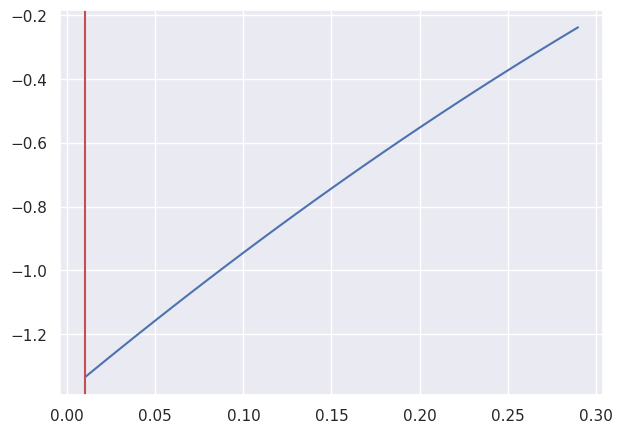

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(lst, scores)
plt.axvline(min, c='r')
plt.show()

In [ ]:
df_ansamble['predictions'].to_csv('result_ensa.csv', index=False)

# Extra

In [ ]:
!pip install skops

In [ ]:
# from skops.hub_utils import download
# from skops.io import load
# download("scikit-learn/Fish-Weight", "/content/extra")
# # # make sure model file is in skops format
# # # if model is a pickle file, make sure it's from a source you trust
# # model = load("path_to_folder/example.pkl")